<a href="https://colab.research.google.com/github/sairachawla/data-science-columbia/blob/main/COVID_Hackathon_Model_Submission_Notebook(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to repo:
[https://github.com/sairachawla/data-science-columbia](https://github.com/sairachawla/data-science-columbia)

The assignment is under COVID_Hackathon_Model_Submission_Notebook

## 1. Use Google Drive link to view a folder I shared with @columbia.edu google drive users
https://drive.google.com/drive/folders/18O-BnGOIw9ZiUwy17Uk_361xyfTF-qAN?usp=sharing
## 2. Right click folder and click "Add shortcut to Drive"
This will be sure the zipfile in this folder is accessible in your personal drive folder


In [1]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Mounted at /content/drive


In [2]:
# Import data and unzip files to folder
!unzip /content/drive/MyDrive/GR5074//assignment02/covid_radiography_data/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [3]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [4]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-2579.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1097.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3339.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1157.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2970.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3183.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2800.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-696.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-997.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3148.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3165.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3585.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-103.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3342.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-140.png', 'COVID-19_Radiography_Dataset/COVID/images/COV

In [5]:
#Reduce number of images to first 1345 for each category, essentially balancing the data 
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation, essentially scaling the data
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [7]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [8]:
len(image_filepaths)

4032

In [9]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [10]:
len(fnames[2])

1344

In [11]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


COVID  NORMAL  PNEUMONIA
0         1       0          0
1         1       0          0
2         1       0          0
3         1       0          0
4         1       0          0
...     ...     ...        ...
4027      0       0          1
4028      0       0          1
4029      0       0          1
4030      0       0          1
4031      0       0          1

[4032 rows x 3 columns]

### Question 1

Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.)

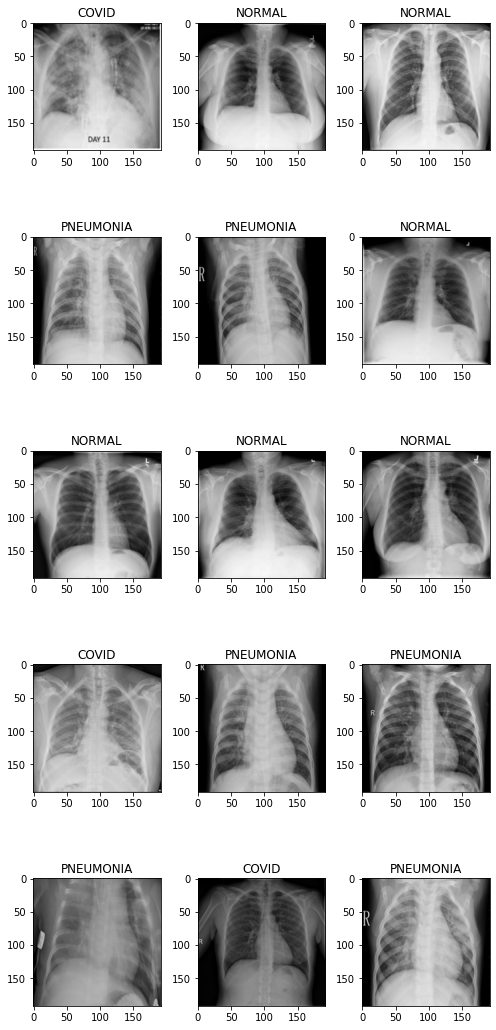

In [12]:
fig,ax=plt.subplots(5,3)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range (3):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title(y_labels[l])
        
plt.tight_layout()

### Question 2

Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

The dataset contains image data of three categories: COVID, pnemonia, and normal. Building a predictive model on this image data would allow medical professionals to better predict and diagnosis individuals using technology.

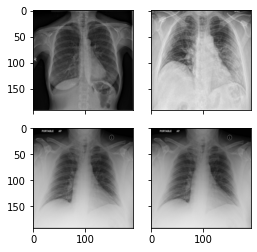

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[1][1])
im4 =preprocessor(fnames[1][1])

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

In [14]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [15]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [16]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [17]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [18]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

KeyboardInterrupt: ignored

In [ ]:
model.save("model.h5", save_format="h5")

In [19]:
# Begin to submit models to image classification leaderboard
import sys
!{sys.executable} -m pip install aimodelshare
# Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 KB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.0/147.0 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.3/96.3 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 24.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━

In [20]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

OSError: ignored

In [21]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f180cbc2550>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 2s 43ms/step


In [22]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 304

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

In [ ]:
#Submit Model with predictions only (if you cannot save an onnx file): 

#-- Generate predicted y values (Model 1)
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = None,
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

### Question 3

Run at least three prediction models to try to predict x-ray images well.
Use transfer learning for at least one of these models
Discuss which models performed better and point out relevant hyper-parameter values for successful models.
Submit your best three models to the leader board for the Covid X-ray Diagnostic AI Model Share competition.

In [23]:
## building models 

In [24]:
import tensorflow as tf

with tf.device('/device:GPU:0'):
  model1 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=8, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(75, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

model1.compile(
  optimizer="adam", 
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])
  
# Fitting the CNN to the Training set
model1.fit(X_train, y_train, 
                  epochs = 1, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7044

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - 69s 968ms/step - loss: 0.6562 - accuracy: 0.7044 - val_loss: 0.4713 - val_accuracy: 0.8069


In [25]:
model1.save("model1.h5", save_format="h5")

In [26]:
from keras.regularizers import l2

with tf.device('/device:GPU:0'):
  model2 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=8, padding='same', activation='relu', input_shape=(192, 192, 3), kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(75, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=l2(0.01)),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

model2.compile(
  optimizer="adam", 
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])
  
# Fitting the CNN to the Training set
model2.fit(X_train, y_train, 
                  epochs = 1, verbose=1,validation_split=.2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - ETA: 0s - loss: 3.1314 - accuracy: 0.6346

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - 79s 1s/step - loss: 3.1314 - accuracy: 0.6346 - val_loss: 2.6151 - val_accuracy: 0.4463


In [27]:
model2.save("model2.h5", save_format="h5")

In [28]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

base_model3 = VGG16(input_shape=(192,192,3), include_top=False, weights='imagenet')
base_model3.trainable = False

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
flat1 = Flatten()(base_model3.layers[-1].output)
class1 = Dense(75, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)

model3 = Model(inputs=base_model3.inputs, outputs=output)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model3.fit(X_train, y_train,
          epochs = 1, verbose=1,validation_split=.2)

58889256/58889256 [==============================] - 0s 0us/step


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - ETA: 0s - loss: 1.1873 - acc: 0.3545 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - 1447s 21s/step - loss: 1.1873 - acc: 0.3545 - val_loss: 1.0696 - val_acc: 0.3515


In [29]:
model3.save("model3.h5", save_format="h5")

In [30]:
## submitting models

In [32]:
from aimodelshare.aimsonnx import model_to_onnx
onnx_model1 = model_to_onnx(model1, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model1.onnx", "wb") as f:
    f.write(onnx_model1.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f1636126310>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [33]:
onnx_model2 = model_to_onnx(model2, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f1634d520d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name', 'regularizer'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUT

In [34]:
onnx_model3 = model_to_onnx(model3, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model3.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f16c8d7f3a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [35]:
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index_model1 = model1.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels_model1 = [y_train.columns[i] for i in prediction_column_index_model1]

prediction_column_index_model2 = model2.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels_model2 = [y_train.columns[i] for i in prediction_column_index_model2]

prediction_column_index_model3 = model3.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels_model3 = [y_train.columns[i] for i in prediction_column_index_model3]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 13s 323ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 13s 323ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self'

In [36]:
# Submit Model to Competition Leaderboard
experiment.submit_model(model_filepath = "model1.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_model1)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 367

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [37]:
experiment.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_model2)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 368

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [38]:
experiment.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_model3)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 369

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [76]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

In [40]:
data=experiment.compare_models([307, 308, 309], verbose=1)
experiment.stylize_compare(data)

/usr/local/lib/python3.9/dist-packages/aimodelshare/aimsonnx.py:1242: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(df_styled.render()))


Model2 seemed to perform the best. I believe this is due to the batch normalization and l2 regularization. For the next three models, I plan on using Alexnet without regularization or batch normalization, Alexnet with regularization and batch normalization, and a ResNet model.

### Question 4 

After you submit your first three models, describe your best model with your team via your team slack channel
Fit and submit up to three more models after learning from your team.
Discuss results

In [41]:
with tf.device('/device:GPU:0'):
  model4 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=8, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(75, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

model4.compile(
  optimizer="adam", 
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])
  
# Fitting the CNN to the Training set
model4.fit(X_train, y_train, 
                  epochs = 1, verbose=1,validation_split=.2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - ETA: 0s - loss: 1.0136 - accuracy: 0.4434WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f16c8cfbf70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - 134s 2s/step - loss: 1.0136 - accuracy: 0.4434 - val

In [42]:
model4.save("model4.h5", save_format="h5")

In [43]:
with tf.device('/device:GPU:0'):
  model5 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=8, padding='same', activation='relu', input_shape=(192, 192, 3), kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(75, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

model5.compile(
  optimizer="adam", 
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])
  
# Fitting the CNN to the Training set
model5.fit(X_train, y_train, 
                  epochs = 1, verbose=1,validation_split=.2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - ETA: 0s - loss: 3.7409 - accuracy: 0.5306WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f1631596d30> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - 137s 2s/step - loss: 3.7409 - accuracy: 0.5306 - val

In [44]:
model5.save("model5.h5", save_format="h5")

In [45]:
from keras.applications import ResNet50
from keras.models import Sequential,Model
from keras.preprocessing import image
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten
from keras import backend as K

base_model6 = ResNet50(input_shape=(192,192,3), include_top=False, weights='imagenet')
base_model6.trainable = False

# Create new classifier layers (and plug into output of last layer from above model using "model.layers[-1].output")
gap1 = GlobalAveragePooling2D()(base_model6.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)

model6 = Model(inputs=base_model6.inputs, outputs=output)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model6.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model6.fit(X_train, y_train,
          epochs = 1, verbose=1,validation_split=.2)

94765736/94765736 [==============================] - 1s 0us/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==============================] - ETA: 0s - loss: 1.4605 - acc: 0.3335WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f1634b11af0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
69/69 [==========================

In [46]:
model6.save("model6.h5", save_format="h5")

In [47]:
onnx_model4 = model_to_onnx(model4, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model4.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f16315968b0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [48]:
onnx_model5 = model_to_onnx(model5, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model5.onnx", "wb") as f:
    f.write(onnx_model5.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f1634d1a0d0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name', 'regularizer'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUT

In [49]:
onnx_model6 = model_to_onnx(model6, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model6.onnx", "wb") as f:
    f.write(onnx_model6.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f1631601af0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [50]:
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index_model4 = model4.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels_model4 = [y_train.columns[i] for i in prediction_column_index_model4]

prediction_column_index_model5 = model5.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels_model5 = [y_train.columns[i] for i in prediction_column_index_model5]

prediction_column_index_model6 = model6.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels_model6 = [y_train.columns[i] for i in prediction_column_index_model6]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 18s 430ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 24s 596ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self'

In [51]:
experiment.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_model4)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 370

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [52]:
experiment.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_model5)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 371

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [53]:
experiment.submit_model(model_filepath = "model6.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_model6)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 372

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [54]:
data=experiment.compare_models([315, 316, 317], verbose=1)
experiment.stylize_compare(data)

/usr/local/lib/python3.9/dist-packages/aimodelshare/aimsonnx.py:1242: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  display(HTML(df_styled.render()))


Interestingly, Model 4 seemed to perform the best which was just a standard Alexnet model. With batch normalization and l2 regularization, the model didn't perform as well. Finally, model5 and model6 seemed to underperform significantly in comparison to the other models.

### Question 5

Try to use augmented data to rerun at least one model and submit it to the leaderboard.
Discuss results.

In [63]:
filenamelist = fnames[0] + fnames[1] + fnames[2]
len(filenamelist)

4032

In [64]:
len(y_labels)

4032

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train_datagen,X_test_datagen,y_train_datagen,y_test_datagen=train_test_split(filenamelist,y_labels,test_size=0.20,random_state=42)

import pandas as pd
trainingdata=pd.DataFrame.from_dict({'X': X_train_datagen, 'y': y_train_datagen})
testdata=pd.DataFrame.from_dict({'X': X_test_datagen, 'y': y_test_datagen})

trainingdata.head()


X          y
0  COVID-19_Radiography_Dataset/COVID/images/COVI...      COVID
1  COVID-19_Radiography_Dataset/Normal/images/Nor...     NORMAL
2  COVID-19_Radiography_Dataset/Normal/images/Nor...     NORMAL
3  COVID-19_Radiography_Dataset/Viral Pneumonia/i...  PNEUMONIA
4  COVID-19_Radiography_Dataset/Normal/images/Nor...     NORMAL

In [68]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                                           zoom_range=0.5,
                                           horizontal_flip=True,
                                           vertical_flip=True,) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_dataframe(dataframe=trainingdata,
                                                           directory=None, # reading in from folder where subfolders are target names
                                                           x_col='X',
                                                           y_col='y',
                                                           target_size=(192, 192),
                                                           batch_size=1,
                                                           class_mode='categorical',
                                                           shuffle=True)

val_data_gen = validation_image_generator.flow_from_dataframe(dataframe=testdata,
                                                              directory=None,
                                                              x_col='X',
                                                              y_col='y',
                                                              target_size=(192, 192),
                                                              batch_size=1,
                                                              class_mode='categorical')

Found 3225 validated image filenames belonging to 3 classes.
Found 807 validated image filenames belonging to 3 classes.


In [69]:
with tf.device('/device:GPU:0'):
  model7 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=8, padding='same', activation='relu', input_shape=(192, 192, 3), kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(75, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dense(15, activation='relu', kernel_regularizer=l2(0.01)),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

model7.compile(
  optimizer="sgd", 
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

In [71]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.


      # fits the model on batches with real-time data augmentation:
      model7.fit(train_data_gen,
                    steps_per_epoch=len(trainingdata) / 1, epochs=10, #steps per epoch should be data samples/ image batch size but we have a small dataset, 
                                                                      #so we do not adjust our data into batches.
                    validation_data=val_data_gen)


Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3225/3225 [==============================] - ETA: 0s - loss: 2.5650 - accuracy: 0.5581WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f160d089790> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3225/3225 [==============================] - 260s 79ms/step - loss: 2.5650 - a

In [72]:
model7.save("model7.h5", save_format="h5")

In [73]:
onnx_model7 = model_to_onnx(model7, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model7.onnx", "wb") as f:
    f.write(onnx_model7.SerializeToString())

Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7f160d0a3790>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('name', 'regularizer'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUT

In [74]:
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index_model7 = model7.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels_model7 = [y_train.columns[i] for i in prediction_column_index_model7]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 13s 309ms/step


In [75]:
experiment.submit_model(model_filepath = "model7.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels_model7)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 389

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


Augmented data increased the performance of my best substantially. 

### Question 6
Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.

Overall, I tried Lenet and Alexnet models with a variety of different implementations regarding regularization and batch normalization along with 2 transfer learning models. I think it is interesting that my simpler model with batch normalization and l2 regularization performed best, especially on augmented data. 